In [1]:
import os
os.chdir('/Users/layne/Desktop/pydatasci')
os.getcwd()

'/Users/layne/Desktop/pydatasci'

In [2]:
import pydatasci as pds
from pydatasci import aidb
import os, sqlite3, io, gzip 
import pandas as pd
import numpy as np
import pyarrow
from pyarrow import csv as pc

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
from importlib import reload; aidb.delete_db(True); reload(aidb); aidb.create_db()


=> Success - deleted database file at path:
/Users/layne/Library/Application Support/pydatasci/aidb.sqlite3


=> Success - created database file for machine learning metrics at path:
/Users/layne/Library/Application Support/pydatasci/aidb.sqlite3


=> Success - created the following tables within database:
['algorithm', 'dataset', 'featureset', 'fold', 'foldset', 'hypercombination', 'hyperparamset', 'job', 'label', 'preprocess', 'splitset']



---

In [4]:
dataset = aidb.Dataset.from_file(
	path = 'data/iris.tsv' 
	,file_format = 'tsv'
	,name = 'tab-separated plants'
	,perform_gzip = True
    ,dtype = 'float64'
)

In [5]:
label_name = 'target'

In [6]:
label = dataset.make_label(columns=[label_name])

In [7]:
label_id = label.id

In [8]:
featureset = dataset.make_featureset(exclude_columns=[label_name])

In [9]:
splitset_train75_test25 = featureset.make_splitset(label_id=label_id)

In [10]:
splitset_train68_val12_test20 = featureset.make_splitset(
	label_id = label_id
	, size_test = 0.20
	, size_validation = 0.12
)

---

ToDo - Does Pandas labels probably wants a series too, not a full dataframe? `.as_series()` method?

ToDo - OHE'ing preprocessing.

ToDo - standardscaler preprocessing.

In [11]:
samples = splitset_train75_test25.to_numpy()

In [12]:
train_features = samples["train"]["features"]
test_features = samples["test"]["features"]

In [13]:
train_labels = samples["train"]["labels"]
test_labels = samples["test"]["labels"]

In [14]:
encoder = OneHotEncoder(sparse=False)
train_labels = encoder.fit_transform(train_labels)
test_labels = encoder.fit_transform(test_labels)

In [15]:
model = Sequential()
model.add(Dense(13, input_shape=(4,), activation='relu', kernel_initializer='he_uniform', name='fc1')) # first hidden layer
model.add(Dense(3, activation='softmax', name='output'))
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 13)                65        
_________________________________________________________________
output (Dense)               (None, 3)                 42        
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# Train
history = model.fit(
    train_features
    , train_labels
    , validation_data = (test_features, test_labels)
    , verbose = 0
    , batch_size = 6
    , epochs = 60
)

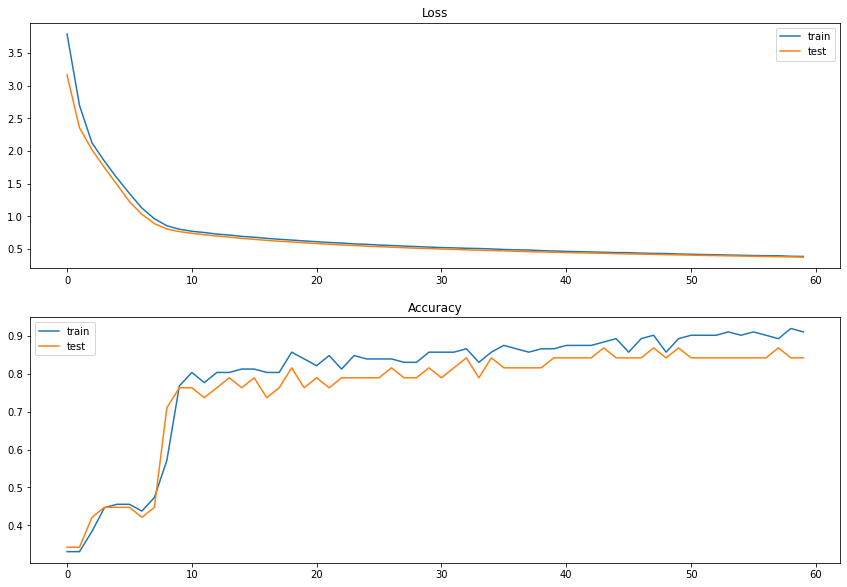

In [18]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

plt.subplots_adjust(top=2, right=2)

plt.show()

---

In [11]:
samples = splitset_train68_val12_test20.to_numpy()

In [12]:
train_features = samples["train"]["features"]
validation_features = samples["validation"]["features"]
test_features = samples["test"]["features"]

In [13]:
train_labels = samples["train"]["labels"]
validation_labels = samples["validation"]["labels"]
test_labels = samples["test"]["labels"]

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

### Preprocess

How it works normally.

In [14]:
preprocess_features_kwargs = {"sparse": False}

^ Alternatively, pass in a dictionary of values for that keyword.

In [15]:
encoder = OneHotEncoder()

^ Or just pass the params directly into the encoder function if you don't want to hypertune on them.

In [16]:
encoder_labels = encoder.set_params(**encode_features_kwargs)

In [17]:
encoder_labels_trained = encoder_labels.fit(train_labels)

In [18]:
train_labels = encoder_labels_trained.transform(train_labels)
validation_labels = encoder_labels_trained.transform(validation_labels)
test_labels = encoder_labels_trained.transform(test_labels)

In [38]:
dir(encoder)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_X',
 '_check_n_features',
 '_compute_drop_idx',
 '_fit',
 '_get_feature',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_transform',
 '_validate_data',
 '_validate_keywords',
 'categories',
 'categories_',
 'drop',
 'drop_idx_',
 'dtype',
 'fit',
 'fit_transform',
 'get_feature_names',
 'get_params',
 'handle_unknown',
 'inverse_transform',
 'set_params',
 'sparse',
 'transform']

Create the preprocess object.

In [19]:
preprocess = aidb.Preprocess.create(
    encode_labels_function = encoder
)

<Preprocess: 1>

In [24]:
feature_encoder = preprocess.preprocess_labels_function.set_params(**preprocess_features_kwargs)

In [25]:
encoder_labels_trained = feature_encoder.fit(train_labels)

In [26]:
train_labels = encoder_labels_trained.transform(train_labels)
validation_labels = encoder_labels_trained.transform(validation_labels)
test_labels = encoder_labels_trained.transform(test_labels)

^^^ Now do the same, but with kwargs stored in the hyperparamset attribute.

### Algorithm

In [52]:
build_model_kwargs = {
    "l1_neuron_count": 9
    , "l2_neuron_count": 9
    , "optimizer": "adamax"
}

In [53]:
def build_model_function(**build_model_kwargs):
    model = Sequential()
    model.add(Dense(l1_neuron_count, input_shape=(4,), activation='relu', kernel_initializer='he_uniform', name='fc1')) # first hidden layer
    model.add(Dense(l2_neuron_count, activation='relu', kernel_initializer='he_uniform', name='fc2'))
    model.add(Dense(3, activation='softmax', name='output'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [25]:
model = build_model_function(**build_model_kwargs)

In [26]:
# model = Sequential()
# model.add(Dense(9, input_shape=(4,), activation='relu', kernel_initializer='he_uniform', name='fc1')) # first hidden layer
# model.add(Dense(9, activation='relu', kernel_initializer='he_uniform', name='fc2'))
# model.add(Dense(3, activation='softmax', name='output'))
# model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 9)                 45        
_________________________________________________________________
fc2 (Dense)                  (None, 9)                 90        
_________________________________________________________________
output (Dense)               (None, 3)                 30        
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
train_model_kwargs = {
    "epochs": 60
    , "batch_size": 3
}

In [54]:
train_model_data = {
    "train":{
        "features": train_features
        ,"labels": train_labels
    },
    "eval":{
        "features": test_features
        ,"labels": test_labels
    }
}

In [55]:
def train_model_function(train_model_data, **train_model_kwargs):
    history = model.fit(
        train_model_data["train"]["features"]
        , train_model_data["train"]["labels"]
        , validation_data = (
            train_model_data["eval"]["features"],
            train_model_data["eval"]["labels"]
        )
        , verbose = 1
        , batch_size = batch_size
        , epochs = epochs
    )
    
    return history

In [52]:
history = train_model_function(train_model_data, **train_model_kwargs)

Epoch 1/60
34/34 [==============================] - 0s 2ms/step - loss: 0.2680 - accuracy: 0.9412 - val_loss: 0.3489 - val_accuracy: 0.8667
Epoch 2/60
34/34 [==============================] - 0s 2ms/step - loss: 0.2672 - accuracy: 0.9412 - val_loss: 0.3443 - val_accuracy: 0.8667
Epoch 3/60
34/34 [==============================] - 0s 2ms/step - loss: 0.2636 - accuracy: 0.9510 - val_loss: 0.3456 - val_accuracy: 0.8667
Epoch 4/60
34/34 [==============================] - 0s 2ms/step - loss: 0.2616 - accuracy: 0.9412 - val_loss: 0.3416 - val_accuracy: 0.8667
Epoch 5/60
34/34 [==============================] - 0s 2ms/step - loss: 0.2597 - accuracy: 0.9412 - val_loss: 0.3415 - val_accuracy: 0.8667
Epoch 6/60
34/34 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.9314 - val_loss: 0.3388 - val_accuracy: 0.8667
Epoch 7/60
34/34 [==============================] - 0s 2ms/step - loss: 0.2552 - accuracy: 0.9412 - val_loss: 0.3371 - val_accuracy: 0.8667
Epoch 8/60
34/34 [==

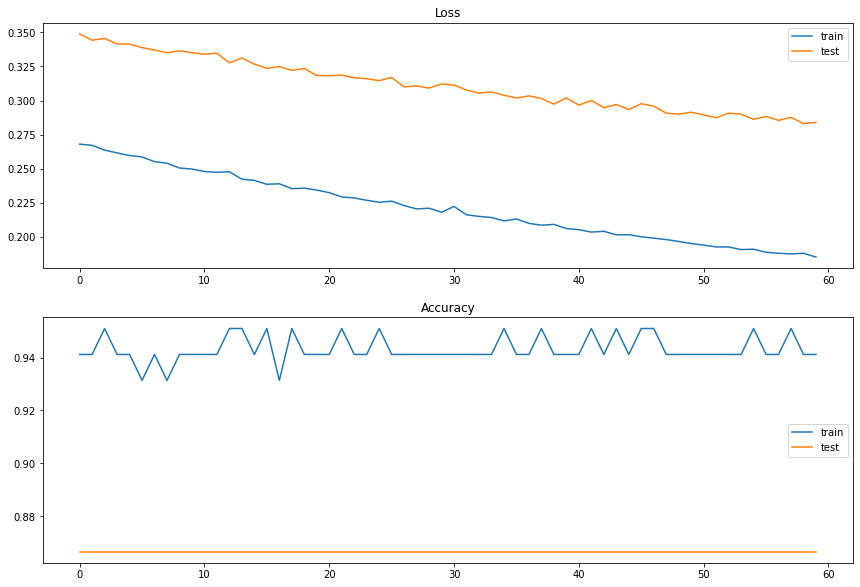

In [53]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

plt.subplots_adjust(top=2, right=2)

plt.show()

---

In [15]:
def evaluate_model_function():
    results = model.evaluate(features, labels, verbose=0)
    print("Loss = " + str(results[0]) + " // Accuracy = " + str(results[1]) )

In [37]:
alg = aidb.Algorithm.create(
    name = "keras dense iris"
	, build_model_function = build_model_function
	, train_model_function = train_model_function
	, evaluate_model_function = evaluate_model_function
)

In [38]:
alg.build_model_function

<function __main__.build_model_function(build_model_params)>

In [39]:
alg.build_model_function(**build_model_kwargs)

In [40]:
mod = alg.build_model_function(**build_model_kwargs)

In [43]:
history = alg.train_model_function(**train_model_kwargs)

NameError: name 'train_features' is not defined

### Jobs